## A Study of Dallas Violent Crime

This project will analyze the Dallas, TX violent crime statistics over a year period, and develop a machine learning model that can predict violent crime types based on victim demographics. Violent crime is defined as four offenses, according to the FBI: murder and non-negligent manslaughter, forcible rape, robbery and aggravated assault. The following questions will be answered:
1. How many violent crimes were reported, and what was the breakdown in victim demographics?
2. Which zip codes had the highest number of violent offenses reported?
3. Using such features as victim demographics, location, and time, can the type of crime be predicted?

Crime data was pulled from the Dallas Open Data site. The data dictionary can be found here: https://www.dallasopendata.com/Public-Safety/Police-Incidents/qv6i-rri7. 

All crimes in the dataset are coded with a NIBRS (National Incident Based Reporting System) code. NIBRS codes are a standardized way to classify what type of crime has occured. This will be used to filter the dataset for violent offenses. The code definitions can be found here: https://ucr.fbi.gov/nibrs/2011/resources/nibrs-offense-codes/view

We'll begin by reading in the data from the Dallas Open Data API for this dataset, and cleaning it before moving on to the analysis.

In [1]:
#Importing in libraries
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

#Connecting to the API for the Police Incidents dataset on the Dallas Open Data website.
#Filtering in the request to only receive data for 2019, and checking for errors.
#Year can be changed from 2019 in this request line:
response = requests.get('https://www.dallasopendata.com/resource/qv6i-rri7.json?Year of Incident=2019&$limit=200000')
print(response.status_code) #A status code of 200 will indicate an error-free response

200


In [2]:
#Converting the API response into a dataframe
js = response.json()
data = pd.read_json(json.dumps(js))

#Looking at the column information
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156815 entries, 0 to 156814
Data columns (total 99 columns):
incidentnum              156815 non-null object
servyr                   156815 non-null int64
servnumid                156815 non-null object
watch                    156815 non-null int64
signal                   149824 non-null object
offincident              156815 non-null object
premise                  156744 non-null object
objattack                149753 non-null object
incident_address         156481 non-null object
ra                       156659 non-null float64
beat                     156669 non-null float64
division                 156673 non-null object
sector                   156724 non-null float64
district                 156624 non-null object
date1                    156815 non-null object
year1                    156815 non-null int64
month1                   156815 non-null object
day1                     156815 non-null object
time1                    

In [3]:
#Printing out a row from the dataset:
print(data.iloc[0,:])

incidentnum                   077652-2019
servyr                               2019
servnumid                  077652-2019-01
watch                                   1
signal         58 - ROUTINE INVESTIGATION
                          ...            
hate                                  NaN
ucr_offense                           NaN
ucr_offdesc                           NaN
ucrcode                               NaN
type                                  NaN
Name: 0, Length: 99, dtype: object


There are a lot of columns in this dataset! On a first glance, the first thing we'll do is modify "geocoded_column." Unlike all the other columns, which contain either numbers or strings, this column contains dictionaries. It will be difficult to do any analysis with the column like this. Because we have the incident addresses elsewhere in the dataframe, let's extract the unique information in this column: latitude and longitude. This would be helpful in case we decide to plot offense locations.

In [4]:
#Making a copy of the dataframe to work with
cleandata=data.copy()

#Extracting the latitude and longitude from the dictionaries, and placing them in their own columns:
cleandata['latitude']=data.geocoded_column.apply(lambda x: np.nan if pd.isnull(x) else x.get('latitude'))
cleandata['longitude']=data.geocoded_column.apply(lambda x: np.nan if pd.isnull(x) else x.get('longitude'))

#Dropping the original geocoded column:
cleandata.drop(columns='geocoded_column',inplace=True)

Next, let's examine the data for duplicate entries. We'll look at incidents with the same incident number (a unique identifier):

In [5]:
#Extracting the duplicates based on incident number, address, and incident type:
duplicates = data.loc[data.duplicated(subset = ['incidentnum', 'incident_address', 'offincident'], keep=False),:].sort_values('incidentnum')

#Looking at the number of potential duplicates:
duplicates.shape

(10330, 99)

There are quite a few duplicates. Because of the large number, let's first export the duplicates to a csv file to get a closer look:

In [6]:
#Exporting the duplicates to a csv file
duplicates.to_csv('duplicates.csv')

After taking a look at the data, the duplicates are due to each line having a different complainant/victim, even if it was the same crime. Because the demographics are important, we will keep these rows. Instead, we'll look for duplicates where all information is the same:

In [7]:
#Extracting the duplicates without specifying specific columns:
duplicates2 = cleandata.loc[cleandata.duplicated(subset=None,keep='first'),:].sort_values('incidentnum')

#Looking at the shape of the data:
duplicates2.shape

(0, 100)

As it turns out, there are no two rows which are exactly alike. 

For the next step, let's drop columns not useful for an analysis and/or that don't have enough data. Information not needed includes identifying information for victims like names and contact information. We'll keep all other columns, since they are relevant to either the crime, area, victim, or officers involved.

In [8]:
#Dropping columns where the majority of entries are NaN, and aren't relevant:
cleandata.dropna(axis=1, thresh=600, inplace=True)

#Dropping columns with identifying information (victim's home addresses, etc), or that are otherwise not useful:
cleandata.drop(columns=['compname','comphaddress','comphzipcode','compcity','compstate','x_coordinate','y_cordinate', 'compbusname','compbaddress','compbphone'], inplace=True)

This concludes the data cleaning. Now we will extract the rows where the NIBRS code indicates a violent crime occured. We will put this into a separate dataframe, and try to gain inights from this data. 

In [9]:
#List of NIBRS codes that correspond to violent crime:
offenses = ['13A','120','11A','11B','11C','11D','09A']

#Filtering the dataframe by checking if one of the above NIBRS codes is in the nibrs_code column.
#Assigning these rows to a new dataframe:
vdata = cleandata.loc[cleandata.nibrs_code.apply(lambda x: x in offenses),:]

#Checking the dataframe of violent offenses:
vdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9541 entries, 2 to 156812
Data columns (total 84 columns):
incidentnum              9541 non-null object
servyr                   9541 non-null int64
servnumid                9541 non-null object
watch                    9541 non-null int64
signal                   9538 non-null object
offincident              9541 non-null object
premise                  9530 non-null object
objattack                9521 non-null object
incident_address         9486 non-null object
ra                       9540 non-null float64
beat                     9541 non-null float64
division                 9541 non-null object
sector                   9541 non-null float64
district                 9539 non-null object
date1                    9541 non-null object
year1                    9541 non-null int64
month1                   9541 non-null object
day1                     9541 non-null object
time1                    9541 non-null object
date1dayofyear   

In [10]:
#Counting up the total number of offenses by NIBRS code:
code_group = vdata.groupby('nibrs_crime')
total_crimes= code_group['incidentnum'].count().sort_values(ascending=False)
total_crimes

nibrs_crime
ROBBERY-INDIVIDUAL                    3728
AGG ASSAULT - NFV                     3672
ROBBERY-BUSINESS                      1990
MURDER & NONNEGLIGENT MANSLAUGHTER     151
Name: incidentnum, dtype: int64

Based on the above data, the most common crime type is robbery of an individual, and the least is murder/nonnegligent manslaughter. The categories for this dataset are very uneven, which will affect the machine learning portion of this project. For now, let's look at the trend of crime over the year period.

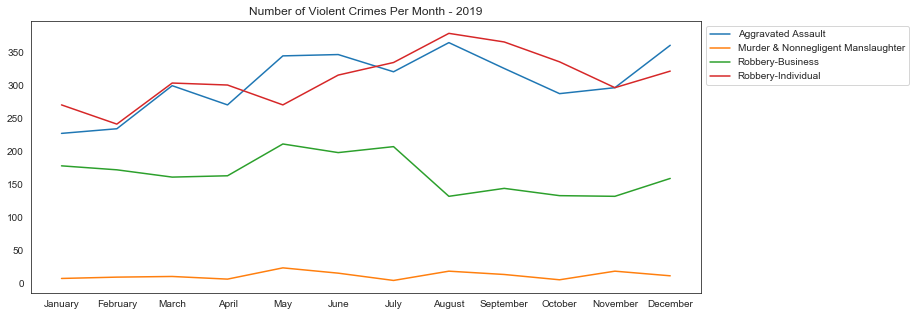

In [11]:
#Aggregating number of crimes by month:
crimes_month = pd.pivot_table(index='month1',columns='nibrs_crime', aggfunc='count', values='incidentnum',data=vdata)
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
crimes_month = crimes_month.reindex(months)
crimes_month.reset_index(inplace=True)

#Plotting number of crimes per month, by category
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(crimes_month.month1, crimes_month.iloc[:,1],label = 'Aggravated Assault')
ax.plot(crimes_month.month1, crimes_month.iloc[:,2],label = 'Murder & Nonnegligent Manslaughter')
ax.plot(crimes_month.month1, crimes_month.iloc[:,3],label = 'Robbery-Business')
ax.plot(crimes_month.month1, crimes_month.iloc[:,4],label = 'Robbery-Individual')
ax.legend(bbox_to_anchor=(1,1))
plt.title('Number of Violent Crimes Per Month - 2019')
plt.show()

Crime peaked for all crime types during the spring and summer months. Generally speaking, May and August are the worst months for crime. Aggravated assaults and robbery of an individual had an overall trend upward throughout the year. Meanwhile, robbery of a business had an overall trend down, and murder/nonnegligent homicide neither increased nor decreased as a whole.

Now let's examine the crime statistics by victim demographics (race and sex).

In [12]:
#Aggregating the crimes by race:
crimes_race = pd.pivot_table(vdata, index='nibrs_crime',columns='comprace',values ='incidentnum',aggfunc='count')
crimes_race

comprace,American Indian or Alaska Native,Asian,Black,Hispanic or Latino,Middle Eastern,Native Hawaiian/Pacific Islander,Unknown,White
nibrs_crime,,,,,,,,
AGG ASSAULT - NFV,7.0,24.0,1784.0,1147.0,30.0,2.0,6.0,657.0
MURDER & NONNEGLIGENT MANSLAUGHTER,NaN,NaN,95.0,43.0,NaN,NaN,1.0,11.0
ROBBERY-BUSINESS,NaN,48.0,256.0,429.0,88.0,4.0,12.0,211.0
ROBBERY-INDIVIDUAL,5.0,46.0,980.0,1883.0,77.0,11.0,5.0,698.0


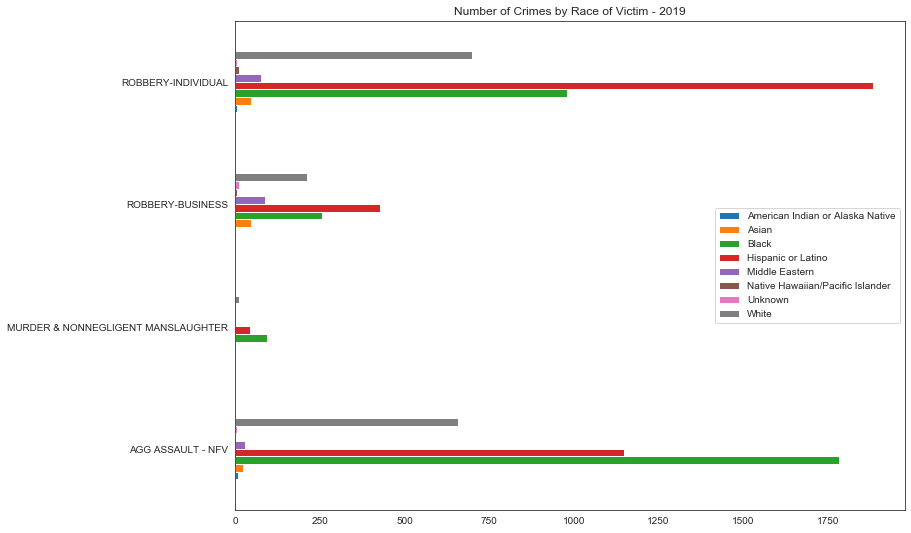

In [13]:
#Plotting a graph of the crimes by race pivot table:
sns.set_style('white')
crimes_race.plot.barh(figsize=(12,9))
plt.title('Number of Crimes by Race of Victim - 2019')
plt.ylabel('')
plt.legend()
plt.show()

In [14]:
#Aggregating the crimes by sex:
crimes_sex = pd.pivot_table(vdata,index='nibrs_crime',columns='compsex',values='incidentnum',aggfunc='count')

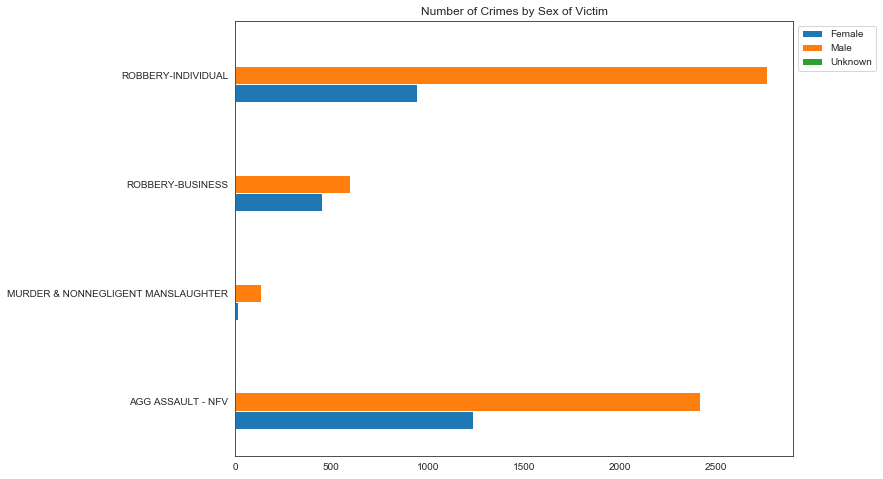

In [15]:
#Graph of crimes by sex:
sns.set_style('white')
crimes_sex.plot.barh(figsize=(10,8))
plt.title('Number of Crimes by Sex of Victim')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('')
plt.show()

Now we can infer several things about dataset itself and crimes committed in the city of Dallas. 

Based on the above crime totals and charts, we can see the data does not include any victims of sexual assault. As such, the scope of this project will be limited to violent crimes excluding rape. Also, this is an uneven dataset, with the most common crime (robbery of a person) occuring almost 25 times more than the least reported crime (murder/non-negligent manslaughter). This will likely have an effect on our ability to accurately predict crime types.

As for crimes, the most common victims of all violent crime types were men. In fact, they far outpaced women as crime victims except where the crime was the robbery of a business. For race, Hispanics and blacks were the most common crime victims of any given crime type. Blacks were the most common aggravated assualt and murder victims, whereas Hispanics were the most common victims of robbery.

For the next section, let's determine the zip codes where the most crime happened.

In [16]:
#Aggregating the type of crime by zip code:
top_crime_zip = vdata.groupby('zip_code')['incidentnum'].count().sort_values(ascending=False).head(10)
print('Zip codes with the most violent crimes:',top_crime_zip)

Zip codes with the most violent crimes: zip_code
75216.0    677
75217.0    640
75228.0    511
75220.0    485
75243.0    483
75211.0    426
75224.0    417
75215.0    386
75227.0    386
75241.0    348
Name: incidentnum, dtype: int64


Most of these zip codes all reside in an area of Dallas colloquially known as "South Dallas." A quick search of the US Census website confirms that these zip codes have high levels of poverty. For example, zip code 75216 has 37.3% of individuals below the poverty level. This would be an interesting feature to add the dataset at a later time for analysis.

For the last section of this project, we will attempt to use machine learning to predict crime types. First, we'll determine what features to use in the classification models. Next, we'll take a sample of the dataset to train the models, and test it using the remaining data. Because there are several classification models that might be relevant here, we'll use several to see which is the best (if any). Specifically,  we will use the k-nearest neighbors, decision tree, and random forest classification algorithms for comparison.

For the purposes of these models, the features we are interested in using are: location, date, time, and victim demographics. Most of these are not numerical. These will need to be encoded or translated to numbers (in the case of Months, for example) in order to be useful. We will also need to remove rows with blank information in these key fields.

In [17]:
#Replacing data in the race and sex columns that are coded as 'Unknown', to blanks (null values):
vdata_ml = vdata.copy()
vdata_ml.comprace = vdata_ml.comprace.replace('Unknown','')
vdata_ml.compsex = vdata_ml.compsex.replace('Unknown','')

In [18]:
#Filtering out null values:
mask = (vdata_ml.comprace.notnull()) & (vdata_ml.compsex.notnull()) & (vdata_ml.compage.notnull() & (vdata_ml.premise.notnull()))
vdata_ml = vdata_ml.loc[mask,:]

In [19]:
#Then, creating dummies out of the rest of the demographic categories:
sex_d = pd.get_dummies(vdata_ml['compsex'])
race_d = pd.get_dummies(vdata_ml['comprace'])
victim_d = pd.get_dummies(vdata_ml['victimtype'])

In [20]:
#Addressing the location columns. In lieu of using the zip codes, will use the division
#column to reduce model complexity.
premise_d = pd.get_dummies(vdata_ml['premise'])
division_d = pd.get_dummies(vdata_ml['division'])

In [21]:
#Creating a dataframe of features and concatenating the dummy variables on:
features = pd.DataFrame(pd.concat([sex_d, race_d, premise_d, division_d, victim_d, vdata_ml.compage], axis=1))

In [22]:
#Addressing the date and time columns. Accounting for the fact that date and time are cyclical, 
#will be using sine and cosine functions on these columns:
from datetime import datetime

#Months. Converting the month name into the corresponding number:
month_num = vdata_ml.month1.apply(lambda x: datetime.strptime(x, '%B').month)

#Creating the sine and cosine of the month to factor in the cyclical nature of time
features['sin_month'] = np.sin((month_num-1)*(2*np.pi/12))
features['cos_month'] = np.cos((month_num-1)*(2*np.pi/12))

#Days (we are already given the day from 1 to 365 in the dataset):
features['sin_day'] = np.sin((vdata_ml.date1dayofyear-1)*(2*np.pi/365))
features['cos_day'] = np.cos((vdata_ml.date1dayofyear-1)*(2*np.pi/365))

#Hours (only using the start time of the offense):

#Converting the time into minutes:
hours = vdata_ml.time1.apply(lambda x: datetime.strptime(x, '%H:%M').hour)
minutes = vdata_ml.time1.apply(lambda x: datetime.strptime(x, '%H:%M').minute)
minute_col = (hours*60)+minutes

#Creating the sine and cosine of the minutes to factor in their cyclical nature
features['sin_time'] = np.sin(minute_col*(2*np.pi/1440))
features['cos_time'] = np.cos(minute_col*(2*np.pi/1440))

In [23]:
#Target column for prediction:
crime_type = vdata_ml.nibrs_crime

Now the feature columns have been prepared and the target column for classification identified. Each model of interest will be run on the dataset, and then the accuracy metrics will be compared side by side. 

The first model to be used is k-nearest neighbors. This model uses the k closest samples in order to compute the classification.

In [24]:
#K-Nearest Neighbors
#Importing libraries from scikit learn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, crime_type, train_size=0.7,random_state=1)

#Instantiating an object of the k nearest neighbors class
neigh = KNeighborsClassifier(n_neighbors=20)

#predicting the classifications using the model
y_pred_knn = neigh.fit(X_train, y_train).predict(X_test)

#Comparing the actual crime from the test set to predictions for accuracy:
comparison_knn = (y_pred_knn==y_test)
print('Overall accuracy of K-Nearest Neighbors:',comparison_knn.sum()/y_test.size)

Overall accuracy of K-Nearest Neighbors: 0.5301299724300906


Next we will use the decision tree model. Decision tree makes a series of decision in a flowchart-like manner, where each node branches based on features in the dataset. When the tree reaches the end (the leaves), it has determined how to classify the data.

In [25]:
#Decision Trees

#importing decision tree library
from sklearn import tree

#Splitting the data into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, crime_type, train_size=0.7, random_state=1)

#Instantiating a decision tree classifier object
clf_dt = tree.DecisionTreeClassifier(class_weight='balanced')

#Fitting the data 
y_pred_dt = clf_dt.fit(X_train2, y_train2).predict(X_test2)

#Comparing the actual crime from the test set to predictions for accuracy:
comparison_dt = (y_pred_dt==y_test2)
y_test2.size
print('Overall accuracy of Decision Tree:',comparison_dt.sum()/y_test2.size)

Overall accuracy of Decision Tree: 0.5667585663647106


Finally, we will use the Random Forest classifier. Random forest uses multiple decision trees from random sub-samples of the dataset, and averages the results. Because of this, it is considered to be extremely accurate, and does not suffer from data overfitting.

In [26]:
#Random Forest

#importing the random forest library
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

#Splitting the data into train and test
X_train3, X_test3, y_train3, y_test3 = train_test_split(features, crime_type, train_size=0.7, random_state=1)

#Instantiating an object of the random forest class
clf_rf = RandomForestClassifier(n_estimators=300, random_state=1, class_weight='balanced')

#Fitting the model on the training data
clf_rf.fit(X_train3, y_train3)

#Making predictions on the test data
y_pred_rf = clf_rf.predict(X_test3)

#Comparing the actual crime from the test set to predictions for accuracy:
comparison_rf = (y_pred_rf==y_test3)
y_test3.size
print('Overall accuracy of Random Forest:',comparison_rf.sum()/y_test3.size)

Overall accuracy of Random Forest: 0.6644348168570303


We see that with each subsequent model that the crime classification accuracy went up. However, that is overall and does not take into account the unevenness of the dataset. Much more data was available for robberies and aggravated assaults than murder. In order to get a more accurate view of how well the models worked, let's use look at a confusion matrix for each:

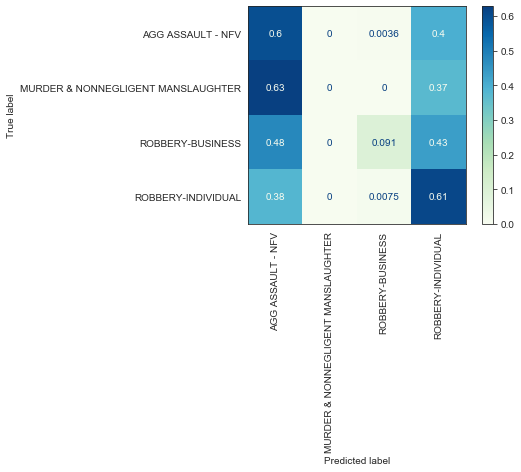

In [27]:
#importing confusion matrix class
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#defining labels for the confusion matrix
crime_labels = sorted(vdata.nibrs_crime.unique())

#Plot confusion matrix for K Nearest Neighbors:
plot_confusion_matrix(neigh,X_test, y_test, normalize='true',labels=crime_labels,
                      xticks_rotation=90, cmap = 'GnBu')
plt.xticks(np.arange(4), crime_labels)
plt.show()

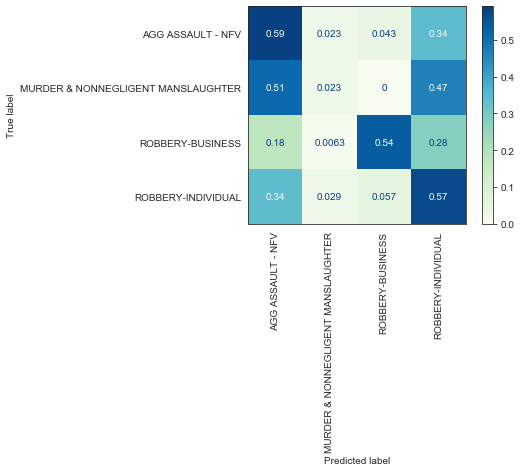

In [28]:
#Plot confusion matrix for Decision Tree:
plot_confusion_matrix(clf_dt,X_test, y_test, normalize='true',labels=crime_labels,
                      xticks_rotation=90, cmap = 'GnBu')
plt.xticks(np.arange(4), crime_labels)
plt.show()

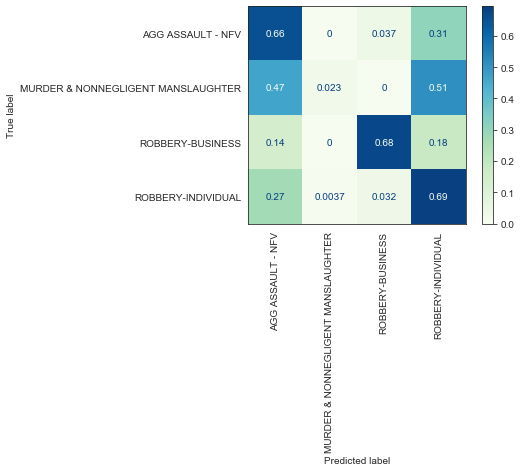

In [29]:
#Plot confusion matrix for Random Forest:
plot_confusion_matrix(clf_rf,X_test, y_test, normalize='true',labels=crime_labels,
                      xticks_rotation=90, cmap = 'GnBu')
plt.xticks(np.arange(4), crime_labels)
plt.show()

Based on the confusion matrices of each model, we can see that the imbalance of the dataset causes issues with correctly labeling the least present crime: Murder and Non-negligent manslaughter. Both Decision Tree and Random Forest only correctly predicted this category about 2.3% of the time, and K Nearest Neighbors was not able to correctly predict this at all. 

The other categories (Aggravated Assault, Robbery-Business, and Robbery-Individual) had thousands of data points from 2019. With each subsequent model, the accuracy improved. K Nearest Neighbors was only able to accurately predict robbery of a business 9.1% of the time, but the other two models improved this to around 60%. For aggravated assault and individual robbery, Both K Nearest Neighbors and Decision Tree accurately predicted in the 60% range. But overall, Random Forest stands out as the most accurate. It was able to accurately predict all of these crimes closer to 70%.

And that concludes this project! We examined crime victim demographics and determined the most victimized gender (men) and races (typically blacks and Hispanics). We also saw that most crimes occured in the spring and summertime.

Information that would be interesting to add to this data includes:
Crimes from previous years
Perpetrator demographics
Poverty statistics by zip code
Census population data

These would likely improve the machine learning models' accuracy. In particular, with more data we could more accurately predict murder. And we would be able to draw more conclusions, such as whether average income of an area is tied to crime. We could also expand the scope of this project to predicting actual crime rates, instead of just crime type. For that we could try several regression techniques to see if any are the most accurate. 

One other way to improve this project would be to increase the granularity of location. We used 'division' as this metric, which divides up the city into regions. However, using zip codes or latitude/longitude would probably increase our models' accuracy considerably.
